# Bank Marketing Campaign: Predict Term Deposit

## Classification Project - EDA

### Author: Andrew McNall - mcnallanalytics@protonmail.com

## Introduction

**Problem:** Determine which bank customers are likely to respond to marketing campaign and make a term deposit.

**Goal:** Develop the best classification model to predict which customers are most likely to respond to a marketing campaign by making a term deposit.

**Data:** Obtained from Kaggel: https://www.kaggle.com/janiobachmann/bank-marketing-dataset. One dataset provided.

**Feature Information:**

Information provided by the bank in the dataset:
    
Client Info:
  
* age - age of client
* job - broad categories for job type of client
* marital - marital status of client
* education - education level of client
* default - yes/no if client is default on a loan
* balance - current account balance at bank
* housing - yes/no if client has a current housing loan with bank
* loan - yes/no if the client has a current loan with the bank
        
Current campaign:
    
* contact - method of contact with client
* duration - length of last contact with client in seconds
* day - date of last contact with client
* month - month of last contact with client
* campaign - number of contacts made with client during campaign
* deposit - yes/no if the client made a term deposit
         
Previous campaigns:

* pdays - number of days since the client was contacted in the last campaign. 999 means not previously contacted.
* previous - number of contacts with client before this campaign
* poutcome - failure/success/nonexistent outcome of previous campaign

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

***

## Data Information

In [2]:
# load dataset

bank_df = pd.read_csv('Data\datasets_4471_6849_bank.csv')

In [3]:
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
bank_df.shape

(11162, 17)

In [5]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [6]:
# check for duplicate records and missing values

print('Number of duplicated records:' , bank_df.duplicated().sum())
print('Number of missing values: ', bank_df.isnull().any())

Number of duplicated records: 0
Number of missing values:  age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
deposit      False
dtype: bool


---

## Exploratory Data Analysis

### Feature Description

In [7]:
# define categorial, numerical and target variables for use in project

categorical_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

numerical_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

target = 'deposit'

In [8]:
deposit = bank_df['deposit'].value_counts()

deposit

no     5873
yes    5289
Name: deposit, dtype: int64

The number of deposits/no deposits is fairly balanced. We'll normalize this target feature, though when we engineer features.

In [9]:
bank_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


Everything appears within normal ranges for our numerical features. The maximum length call ('duration') was over an hour. I might look more closely at that outlier, but the call length is a feature that should be dropped. It's not a feature that we can predict in advance of having the call and it would most likely affect model performance.

In [10]:
bank_df.describe(include = ['O'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,5881,9702,8042,2824,8326,5873


Let's take a closer look at the unique values for the columns so we know what types of categorical values we have.

In [11]:
for i in categorical_vars:
    print(bank_df[i].unique())

['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
['married' 'single' 'divorced']
['secondary' 'tertiary' 'primary' 'unknown']
['no' 'yes']
['yes' 'no']
['no' 'yes']
['unknown' 'cellular' 'telephone']
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
['unknown' 'other' 'failure' 'success']


In [12]:
print(bank_df['job'].value_counts())
print()
print(bank_df['contact'].value_counts())

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64


Thats a lot of unknown contact methods for a bank. We'll look at this feature importance in the models we build and address the unknown contact type in the Actionable Recommendations section of this report. The number of unknown job types seems to be less of an issue since it's less than 1% of the dataset.

### Feature Visualization

In [13]:
# functions for creating plots

def create_violin(size, target, features, data):
    plt.figure(figsize = size)
    for i in range(len(numerical_vars)):
        plt.subplot(6, 4, i + 1)
        sns.violinplot(x = target, y = features[i], data = data)

def create_dist(size, data, features):
    plt.figure(figsize = size)
    for i in range(len(features)):
        plt.subplot(6, 4, i + 1)
        sns.distplot(data[features[i]])

def crossCorrelation(data):
    corr = data.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, xticklabels=corr.columns.values,\
                yticklabels=corr.columns.values)
    print(corr)

In [14]:
# encode target feature for plots

bank_df['deposit'] = bank_df['deposit'].astype('category')

bank_df['deposit'] = bank_df['deposit'].cat.codes

bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


#### 3.2.1 Distribution Plots

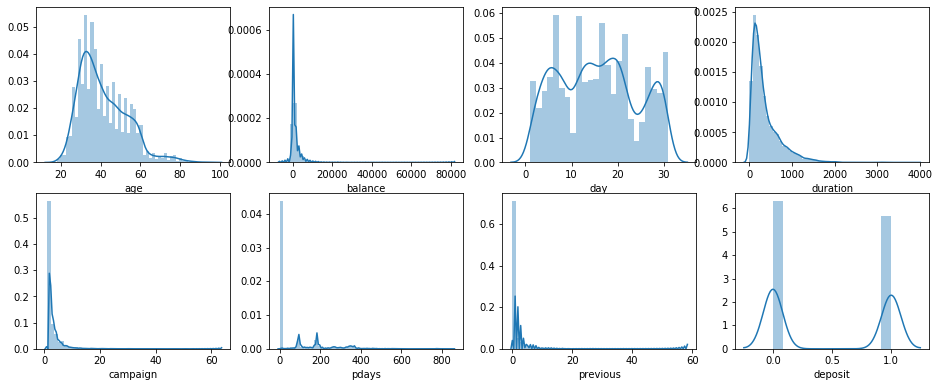

In [15]:
num_vars = bank_df.select_dtypes(exclude = ['object']).columns

create_dist((16, 20), bank_df, num_vars)

The age and balance distributions are both skewed right. Interestingly, the age distribution shows a signficant dropoff at 60. This bank appears to attract more young clients than retirement-age clients who tend to have more resources. The age skew could potentially bias the model, so in a later step I'll apply log transformation on the age feature. We'll not deal with the duration feature; it will be dropped before model building.

#### Violin Plots

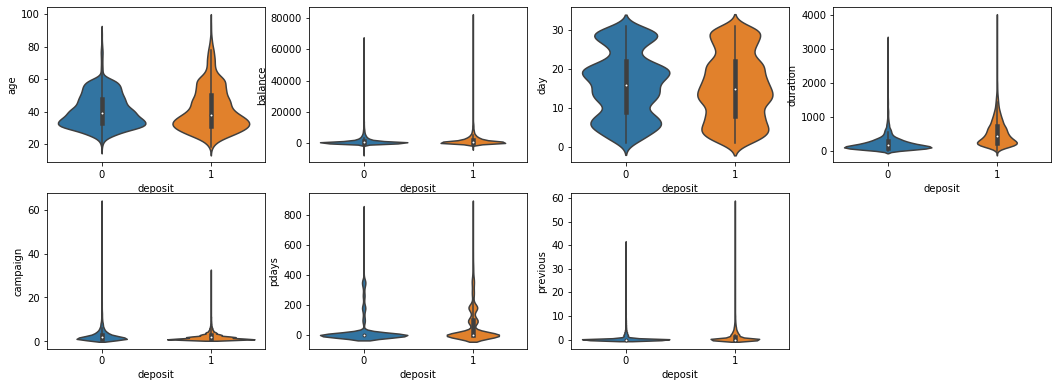

In [16]:
create_violin((18, 20), target, num_vars, bank_df)

Four of the seven distributions look fairly similar, with the exception of long tails and potential outliers. The age distribution gets fatter at the top for people with term deposits, suggesting age will be predictive indicator.

Likewise, the duration of the last contact is noticeably different for those with term deposits compared to those without. This again suggests predictive power. Yet, in any future marketing campaign it's impossible to know the duration of a call with a prospect. Thus, this variable is not useful for a realistic predictive model and will be removed for model development.

#### Heat Map

               age   balance       day  duration  campaign     pdays  \
age       1.000000  0.112300 -0.000762  0.000189 -0.005278  0.002774   
balance   0.112300  1.000000  0.010467  0.022436 -0.013894  0.017411   
day      -0.000762  0.010467  1.000000 -0.018511  0.137007 -0.077232   
duration  0.000189  0.022436 -0.018511  1.000000 -0.041557 -0.027392   
campaign -0.005278 -0.013894  0.137007 -0.041557  1.000000 -0.102726   
pdays     0.002774  0.017411 -0.077232 -0.027392 -0.102726  1.000000   
previous  0.020169  0.030805 -0.058981 -0.026716 -0.049699  0.507272   
deposit   0.034901  0.081129 -0.056326  0.451919 -0.128081  0.151593   

          previous   deposit  
age       0.020169  0.034901  
balance   0.030805  0.081129  
day      -0.058981 -0.056326  
duration -0.026716  0.451919  
campaign -0.049699 -0.128081  
pdays     0.507272  0.151593  
previous  1.000000  0.139867  
deposit   0.139867  1.000000  


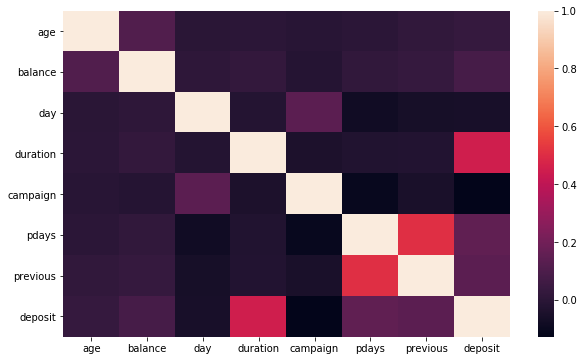

In [17]:
crossCorrelation(bank_df)

Nothing jumps out of the heat map as a strong correlation. The duration of the contact, which I suggested is not a useful predictive variable because it's not something we can know in advance about a potential client, has the highest correlation. No other variable exceeds .15 correlation.

#### Bar Plots of Categorical Features

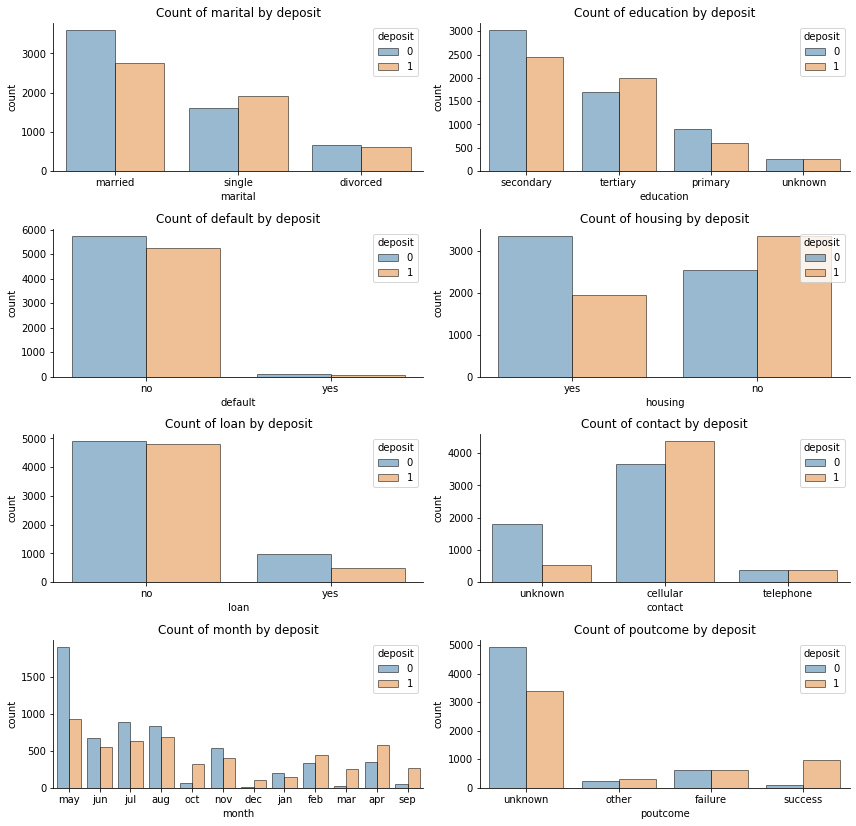

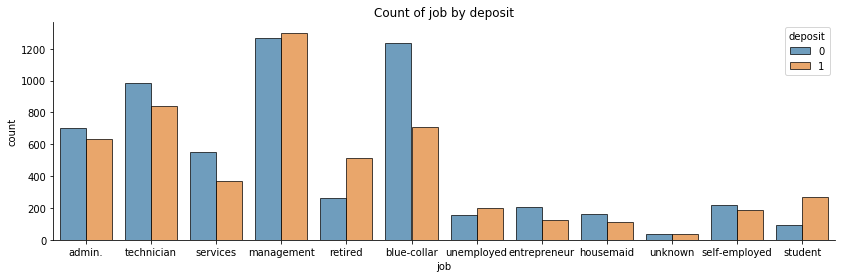

In [18]:
#barplots showing the frequency of each category separated by label

plt.figure(figsize=[12,14])
features = ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
n = 1

for f in features:
    plt.subplot(5,2,n)
    sns.countplot(x = f, hue = 'deposit', edgecolor = 'black', alpha = 0.5, data = bank_df)
    sns.despine()
    plt.title('Count of {} by deposit'.format(f))
    n += 1

plt.tight_layout()
plt.show()

plt.figure(figsize=[14,4])
sns.countplot(x = 'job', hue = 'deposit', edgecolor = 'black', alpha = 0.7, data = bank_df)
sns.despine()
plt.title('Count of job by deposit')
plt.show()

In [19]:
bank_df.to_csv(r'Data\bank-project-data.csv')

Observations about the categorical plots. Interestingly, being married makes it less likely to have a term deposit, while being single indicates you're more likely to have one. So, that feature will have some influence on our results. More education seems to be a modest predictor, but only if you have college-level education. If you do not yet have a housing loan, you're more likely to have a term deposit - maybe saving for a house. Success of the previous campaign seems to have some influence. A few of the job categories - management and retired to be specific - have more term deposits than not, which seems reasonable. Interestingly, being unemployed or a student makes one more likely to have a term deposit. Given the size of the data for those two groups, however, I expect those distinctions to have little effect on the overall model.

Having saved our data to disk in the next notebook we'll build and tune our prediction model.